**Ссылка на телеграм-бота:** t.me/EnglishUAIbot

# **Репетитор по английскому (телеграм-бот)**

In [ ]:
#@title 📦 Установка библиотек (запускаем)
!pip uninstall -y albumentations langchain langchain-core pydantic -q || true
!pip install -q aiogram==3.3.0 nest_asyncio openai gTTS aiofiles requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.5 MB/s eta 0:00:00


In [ ]:
#@title 📦 Импорт модулей и загрузка ключей API (запускаем)

# --- стандартные библиотеки ---
import os, sys, time, json, random, re, collections, datetime
import tempfile, pathlib, threading, asyncio, socket, logging, warnings

# --- внешние пакеты ---
import nest_asyncio
from google.colab import userdata          # если НЕ в Colab — уберите эту строку
from aiogram import Bot, Dispatcher, Router, F, types
from aiogram.types import (
    Message, CallbackQuery,
    InlineKeyboardButton, InlineKeyboardMarkup,
    KeyboardButton, ReplyKeyboardMarkup,
    FSInputFile, ReplyKeyboardRemove,
)
from aiogram.filters import CommandStart, Command
from aiogram.exceptions import TelegramNetworkError
from gtts import gTTS
from openai import AsyncOpenAI
from aiogram.client.session.aiohttp import AiohttpSession

# --- патч для вложенных event-loop’ов в Colab ---
nest_asyncio.apply()

# ─── Загрузка секретов ───
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
TG_BOT_TOKEN   = userdata.get("tg_token")
if not OPENAI_API_KEY or not TG_BOT_TOKEN:
    raise ValueError("⛔️ Сначала добавьте секреты OPENAI_API_KEY и TG_BOT_TOKEN!")

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# --- логирование: «тихий» режим ---
logging.getLogger("aiogram").setLevel(logging.ERROR)
logging.getLogger("aiohttp").setLevel(logging.CRITICAL)
logging.getLogger("aiogram.dispatcher").setLevel(logging.WARNING)
logging.getLogger("aiogram.client.session.aiohttp").setLevel(logging.WARNING)
logging.getLogger("asyncio").setLevel(logging.WARNING)    # глушит «Task was destroyed…»
warnings.filterwarnings("ignore", category=RuntimeWarning) # избавляемся от лишних ворнингов
logging.getLogger("aiogram.dispatcher").setLevel(logging.ERROR)

# --- единый тайм-аут (если пригодится ниже) ---
DEFAULT_TIMEOUT = 20  # секунд

In [ ]:
# @title Сервисные функции

# 🚀 Public API – открытая ячейка для студентов
from openai import AsyncOpenAI
from gtts import gTTS
from aiogram.types import Message, Voice, FSInputFile
import pathlib, asyncio

client = AsyncOpenAI()        # один клиент на всё

state = {}

# ---------------- ВСПОМОГАТЕЛЬНАЯ ФУНКЦИЯ ЗАПУСКА БОТА --------------------
def setup_bot():
    def log(cid, txt):
        print(txt, flush=True)

    # 1) создаём HTTP-сессию с таймаутом в 20 секунд
    session_http = AiohttpSession(timeout=20)

    # 2) инициализируем Bot через эту сессию
    bot = Bot(
        TG_BOT_TOKEN,
        parse_mode="HTML",
        session=session_http
    )

    # 3) Dispatcher и Router оставляем как есть
    dp = Dispatcher()
    router = Router()

    # 4) OpenAI-клиент: если ему нужен таймаут — передайте его в конструктор
    client = AsyncOpenAI(timeout=20)

    # 5) Словарь сессий пользователей
    session = collections.defaultdict(lambda: {
        "mode": None,
        "history": [],
        "ex_answer": None,
        "tts": False
    })

    return bot, dp, router, client, session, log

bot, dp, router, client, session, log = setup_bot()

# 🚀 Public handlers – «витрина» (видят студенты)
from aiogram import Router, F
from aiogram.filters import Command
from aiogram.types  import Message, CallbackQuery, ReplyKeyboardRemove

public = Router()
# ------------------ ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ДИАЛОГА ------------------

def _should_exit(text: str) -> bool:
    """Возвращает True, если текст содержит слово выхода."""
    return any(w in text.lower() for w in EXIT_WORDS)

async def _end_dialogue(m: Message, cid: int):
    """Сбрасывает состояние сессии и уведомляет пользователя."""
    tts_flag = session[cid]["tts"]
    session[cid] = {"mode": None, "history": [], "ex_answer": None, "tts": tts_flag}
    await m.answer(
        "🛑 Диалог завершён. Выберите «Диалог» или «Упражнения».",
        reply_markup=sound_kb(cid)
    )
    log(cid, "Диалог завершён")

def _remember_user(m: Message, text: str):
    """Добавляет сообщение пользователя в историю и логирует."""
    cid = m.chat.id
    session[cid]["history"].append({"role": "user", "content": text})
    log(cid, f"ПОЛЬЗОВАТЕЛЬ: {text}")

async def _send_grammar_feedback(m: Message, text: str):
    """Запрашивает и отправляет исправление ошибок."""
    cid = m.chat.id
    feedback = await grammar_feedback(text)
    await m.answer(feedback, reply_markup=sound_kb(cid))

async def _send_translations(m: Message):
    """Переводит последнюю бот‑фразу и ответ пользователя, отправляет в чат."""
    cid = m.chat.id
    last_bot = next(
        (msg["content"] for msg in reversed(session[cid]["history"]) if msg["role"] == "assistant"),
        ""
    )
    tr = await translate_ru(last_bot, session[cid]["history"][-1]["content"])
    text = f"🌐 <b>Перевод бота</b>: {tr['bot']}\n🌐 <b>Ваш перевод</b>: {tr['user']}"
    await m.answer(text, reply_markup=sound_kb(cid))

async def _make_bot_reply(cid: int, user_text: str) -> str:
    """
    Генерирует следующий реплик бота и добавляет его в историю.
    Использует _chat_complete вместо устаревшего complete_with_history.
    """
    context = session[cid]

    # Составляем и отправляем запрос в LLM
    reply = await _chat_complete(
        user=user_text,
        system=BOT_DIALOGUE_PROMPT.format(**context),
        history=context["history"]
    )

    # Сохраняем ответ в историю
    context["history"].append({"role": "assistant", "content": reply})
    log(cid, f"БОТ: {reply}")
    return reply

async def _deliver_reply(m: Message, cid: int, reply: str):
    """Отправляет текст бота и при включённом TTS — озвучку."""
    await m.answer(f"🤖 {reply}", reply_markup=sound_kb(cid))
    await tts_and_send(reply, cid)

# ---------------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ УПРАЖНЕНИЙ ----------------

# --- стало ---
from aiogram.exceptions import TelegramBadRequest   # добавьте в imports

async def _clean_old(prev_msg):
    """Пытается убрать inline-клавиатуру у прошлого бот-сообщения."""
    try:
        await prev_msg.edit_reply_markup(reply_markup=None)
    except TelegramBadRequest:
        pass

def _pick_keyword(topic: str, cid: int) -> str:
    """Выбирает новое "якорное" слово, избегая повторов."""
    words = TOPIC_WORDS.get(topic, [])
    used = session[cid].setdefault("kw_used", set())
    choice = next((w for w in words if w not in used), random.choice(words))
    used.add(choice)
    return choice

async def _generate_ex(info: dict) -> dict:
    """
    Создаёт упражнение по конкретной ТЕМЕ и KEYWORD, сохраняет ответ
    и объяснение в session, возвращает JSON упражнения.
    Работает независимо от публичного make_exercise().
    """
    cid = info["cid"]

    # 1. Собираем собственный промпт: уровень + ЯВНО указываем topic + keyword
    topic_line = f"• Грамматическая тема: {info['topic']}."
    kw_line    = f"• Используй слово «{info['keyword']}» (или его правильную форму)." if info.get("keyword") else ""
    prompt = (
        EXERCISE_PROMPT.format(level=info["level"]) +
        "\n" + topic_line + ("\n" + kw_line if kw_line else "")
    )

    # 2. Просим модель вернуть ТОЛЬКО JSON
    data = await _json_from_llm(prompt, user="Return ONLY JSON.")

    # 3. Сохраняем в session
    session[cid]["ex_answer"] = data["answer"].lower()
    session[cid]["ex_rule"]   = data.get("explanation", "")

    return data

def _format_message(ex: dict) -> str:
    """
    Формирует текст вопроса + подсказку «hint» (если она есть).
    """
    text = f"🔹 Заполните пропуск:\n{ex['question']}"
    if ex.get("hint"):
        text += f"\n💡 <i>{ex['hint']}</i>"
    return text

async def _send_ex(prev_msg, info):
    """Оркестратор: очистка, выбор, генерация, отправка, лог."""
    await _clean_old(prev_msg)
    cid = prev_msg.chat.id
    info_with_ctx = {**info, 'cid': cid, 'keyword': _pick_keyword(info['topic'], cid)}
    ex = await _generate_ex(info_with_ctx)
    text = _format_message(ex)
    await bot.send_message(cid, text, reply_markup=skip_kb())
    log(cid, f"Задание: {ex['question']}")

# ---------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ GPT ----------

async def _chat_complete(user: str, *, system: str | None = None, history: list | None = None, temperature: float = 0.6) -> str:
    """Базовая обёртка вокруг client.chat.completions.create."""
    msgs = []
    if system:
        msgs.append({"role": "system", "content": system})
    if history:
        msgs.extend(history[-10:])
    msgs.append({"role": "user", "content": user})
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=msgs,
        temperature=temperature
    )
    return r.choices[0].message.content

async def _json_from_llm(prompt: str, *, user: str = "", system: str | None = None) -> dict:
    """Отправляет промпт, пытается распарсить JSON-ответ."""
    raw = await _chat_complete(user or prompt, system=system or prompt, history=None)
    raw = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.S)
    return json.loads(raw)

async def _generate_scenarios(n: int) -> list[str]:
    """Запрашивает у LLM n строк‑сценариев; при нехватке дополняет фейками."""
    seed = datetime.datetime.utcnow().isoformat(timespec="seconds")
    prompt = SCENARIO_BUILDER_PROMPT.format(seed=seed, n=n)
    resp = await _chat_complete(prompt, temperature=0.9)
    lines = [ln.strip() for ln in resp.splitlines() if " — " in ln and " / " in ln]

    # Дополнение фиктивными вариантами, если GPT вернул меньше, чем нужно
    while len(lines) < n:
        fake_place = random.choice(["Кафе", "Парк", "Поезд"])
        fake_roles = random.sample(["Клиент", "Покупатель", "Пассажир", "Менеджер"], 2)
        lines.append(f"{fake_place} — Вы: {fake_roles[0]} / Бот: {fake_roles[1]}")
    return lines[:n]


def _as_keyboard(lines: list[str]) -> ReplyKeyboardMarkup:
    """Преобразует список строк в ReplyKeyboardMarkup."""
    rows = [[KeyboardButton(text=ln)] for ln in lines]
    return ReplyKeyboardMarkup(resize_keyboard=True, keyboard=rows)


# -------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ХЭНДЛЕРОВ --------

def _reset_session(cid: int, *, keep_tts: bool = False):
    """Очищает состояние пользователя."""
    tts_flag = session[cid]["tts"] if keep_tts and cid in session else False
    session[cid] = {"mode": None, "history": [], "ex_answer": None, "tts": tts_flag}


def _init_dialog_state(cid: int, raw_text: str):
    """Разбирает строку сценария и заполняет session для диалога."""
    place, roles = raw_text.split(" — ")
    user_role, bot_role = roles.split("/")
    session[cid].update(
        mode="chat",
        place=place.strip(),
        user_role=user_role.strip(),
        bot_role=bot_role.strip(),
        history=[]
    )
    log(cid, f"Сценарий: {place.strip()} — {user_role.strip()} / {bot_role.strip()}")

async def _make_first_greet(cid: int) -> str:
    """
    Генерирует первую реплику ассистента и сразу кладёт её в history.
    Использует _make_bot_reply (в нём уже есть логирование и добавление в историю).
    """
    return await _make_bot_reply(cid, "Start the conversation.")


async def _voice_to_text(m: Message) -> str:
    """Транскрибирует voice, возвращает текст или бросает ошибку."""
    try:
        return await transcribe_voice(m.voice)
    except Exception as e:
        await m.answer(f"❌ Не удалось распознать голос: {e}")
        raise

# ---------- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ STT TTS ----------

async def _download_voice(v: types.Voice) -> pathlib.Path:
    """Скачивает voice в .ogg-файл и возвращает путь."""
    tmp_dir = tempfile.mkdtemp()
    path = pathlib.Path(tmp_dir) / f"{v.file_unique_id}.ogg"
    await bot.download(v, path)
    return path

async def _ensure_english(text: str, path: pathlib.Path) -> str:
    """Если в тексте есть не-английские символы, используем перевод OpenAI."""
    if not re.search(r"[^A-Za-z0-9 ,.!?'\-]", text):
        return text
    with path.open("rb") as f:
        resp = await client.audio.translations.create(
            model="gpt-4o-mini-transcribe",
            file=f,
            response_format="text"
        )
    return (resp.text or "").strip()


def _generate_tts_file(text: str) -> str:
    """Создаёт mp3 из текста через gTTS и возвращает путь к файлу."""
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3")
    gTTS(text, lang="en").save(tmp.name)
    return tmp.name

#@title 🔒 Hidden core
import asyncio, pathlib, tempfile
from aiogram.types import FSInputFile

#@title 🔒 Hidden core  — «кухня»: полная логика
from aiogram import Router, F
from aiogram.filters import Command
from aiogram.types import Message, CallbackQuery, ReplyKeyboardRemove


# 🔒 Скрытый блок (студенты его не видят)
_core = Router()

# подключение роутеров
dp.include_router(_core)
dp.include_router(public)

def sound_label(cid: int) -> str:
    """
    Смотрим, включён ли звук и сразу берём нужную подпись из словаря.
    """
    return {True: "🔈 Звук ON", False: "🔈 Звук OFF"}.get(
        session[cid]["tts"],          # ключ
        "🔈 Звук OFF"                 # запасной вариант
    )

# вспомогательная функция для извлечения булева ответа из GPT
def extract_bool(response) -> bool:
    """
    Проверяет, есть ли в ответе слово "yes" (в любом регистре).
    """
    return "yes" in response.choices[0].message.content.lower()

# 1) Вынесли проверку озвучки в отдельную функцию
def is_tts_enabled(cid: int) -> bool:
    """
    Проверяет, включена ли озвучка для пользователя.
    Возвращает True, если session[cid]['tts'] == True, иначе False.
    """
    return bool(session[cid].get("tts", False))

# 1) Вынесли отправку файла модели и чтение ответа в отдельную функцию
async def transcribe_file(path: pathlib.Path):
    """
    Открывает файл по пути path, отправляет его в GPT-4o-mini-transcribe
    и возвращает объект ответа.
    """
    with path.open("rb") as f:
        return await client.audio.transcriptions.create(
            model="gpt-4o-mini-transcribe",
            file=f,
            language="en",
            prompt="Transcribe only in English letters."
        )

# 2) Вынесли чистку текста из ответа в отдельную функцию
def extract_transcript_text(response) -> str:
    """
    Берёт поле .text из ответа, заменяет None на пустую строку
    и убирает пробелы по краям.
    """
    return (response.text or "").strip()

# вспомогательная функция для извлечения текста из ответа GPT
def extract_message_content(response) -> str:
    """
    Берёт первый choice и возвращает его .message.content
    """
    return response.choices[0].message.content

# вспомогательная функция для получения JSON-ответа
# вспомогательная функция для получения JSON-ответа
def extract_json(response) -> dict:
    """
    Извлекает JSON-строку из .content ➜ dict.

    ▸ Если словарь содержит поля translation_bot / translation_user
      (возвращает TRANSLATE_PROMPT) — переименовываем в bot / user,
      чтобы их без ошибок использовал _send_translations().

    ▸ Для любых других структур данных ничего не меняем.
    """
    try:
        data = json.loads(response.choices[0].message.content)
    except Exception as e:
        log(None, f"⚠️ JSON parse error: {e}")
        return {}

    if "translation_bot" in data or "translation_user" in data:
        return {
            "bot":  data.get("translation_bot",  "(нет)"),
            "user": data.get("translation_user", "(нет)")
        }

    return data

# вспомогательная функция для форматирования фидбека
def format_grammar_feedback(data: dict) -> str:
    """
    Из JSON-ответа строит строку в виде:
    📝 исправленный_текст — объяснение_ошибок
    """
    return f"📝 {data['corrected']} — {data['explanation_ru']}"

async def _start(m: Message):
    _reset_session(m.chat.id)
    await m.answer("👋 Выберите «Диалог» или «Упражнения».")

async def _stop(m: Message):
    _reset_session(m.chat.id)
    await m.answer("🛑 Бот остановлен. Для перезапуска — /start.")
    await dp.stop_polling()

async def _cmd_dialog(m: Message):
    cid = m.chat.id
    _reset_session(cid, keep_tts=True)
    session[cid]["mode"] = "chat_wait"
    scenarios = await _generate_scenarios(5)
    await m.answer("Выберите сценарий:", reply_markup=await build_scenarios_kb(scenarios))

async def _cmd_ex(m: Message):
    cid = m.chat.id
    _reset_session(cid, keep_tts=True)
    session[cid]["mode"] = "exercise_wait_level"
    await m.answer("Выберите уровень:", reply_markup=levels_kb())

async def _choose_scenario(m: Message):
    cid = m.chat.id
    _init_dialog_state(cid, m.text)
    greet = await _make_first_greet(cid)
    await m.answer(f"🤖 {greet}", reply_markup=sound_kb(cid))
    await tts_and_send(greet, cid)

async def _chat_text(m: Message):
    cid = m.chat.id
    if _should_exit(m.text):
        await _end_dialogue(m, cid)
        return
    _remember_user(m, m.text)
    await _send_grammar_feedback(m, m.text)
    await _send_translations(m)
    reply = await _make_bot_reply(cid, m.text)
    await _deliver_reply(m, cid, reply)

async def _chat_voice(m: Message):
    cid = m.chat.id
    txt = await _voice_to_text(m)             # распознали
    if not txt:                               # пустая расшифровка
        return

    await m.answer(f"🗣 <i>Вы сказали:</i> {txt}")

    # --- далее точно такой же поток, как для текста ---
    if _should_exit(txt):
        await _end_dialogue(m, cid)
        return

    _remember_user(m, txt)
    await _send_grammar_feedback(m, txt)
    await _send_translations(m)
    reply = await _make_bot_reply(cid, txt)
    await _deliver_reply(m, cid, reply)

async def _toggle_tts(m: Message):
    cid = m.chat.id
    session[cid]["tts"] ^= True
    await m.answer("🔔 Готово!", reply_markup=sound_kb(cid))

async def _pick_level(m: Message):
    cid = m.chat.id
    state[cid] = {"level": m.text}
    session[cid]["mode"] = "exercise_wait_topic"
    await m.answer(f"Темы уровня {m.text}:", reply_markup=topics_kb(m.text))

async def _pick_topic(m: Message):
    cid = m.chat.id
    state[cid]["topic"] = m.text
    session[cid]["mode"] = "exercise"
    await m.answer("▶️ Упражнение начинается…", reply_markup=ReplyKeyboardRemove())
    await _send_ex(m, state[cid])

async def _skip(c: CallbackQuery):
    await _send_ex(c.message, state.get(c.from_user.id, {}))

async def _check_answer(m: Message):
    cid = m.chat.id
    user_txt = m.text.strip().lower()
    correct = session[cid]["ex_answer"]
    explanation = session[cid].get("ex_rule", "")
    ok = await is_answer_correct(user_txt, correct)
    mark = "✅" if ok else "❌"
    reply = f"{mark} Правильный ответ: <b>{correct}</b>"
    if explanation:
        reply += f"\n📌 <i>{explanation}</i>"
    await m.answer(reply)
    await _send_ex(m, state[cid])

async def _fb(m: Message):
    if session[m.chat.id]["mode"] is None:
        await m.answer("Пожалуйста, выберите режим (Диалог / Упражнения).")

# ---------- RUNNER ----------
_THREAD = "_bot_runner_thread"

def run_bot():
    old_thread = globals().get(_THREAD)
    if old_thread and old_thread.is_alive():
        print("⚠️  Бот уже запущен. Пришлите /stop в чат или дождитесь остановки.", flush=True)
        return

    # --- 1. Подавляем «красные» ERROR от aiogram ---
    logging.getLogger("aiogram.dispatcher").setLevel(logging.WARNING)
    logging.getLogger("aiogram.client.session.aiohttp").setLevel(logging.WARNING)

    dp: Dispatcher = globals()["dp"]
    bot_obj: Bot   = globals()["bot"]

    if not getattr(dp, "_stop_handler_set", False):
        @dp.message(F.text.in_({"/stop", "Стоп"}))
        async def _cmd_stop(m: Message):
            await m.answer("Бот остановлен.")
            await dp.stop_polling()
        dp._stop_handler_set = True

    # --- 2. Новый _polling — перезапуск при сетевых сбоях без стека ---
    async def _polling():
        await bot_obj.delete_webhook(drop_pending_updates=True)
        while True:
            try:
                await dp.start_polling(bot_obj, handle_signals=False)
                break                     # polling завершился — выходим
            except (TelegramNetworkError, socket.error) as e:
                log(0, f"⚠️ Сетевая ошибка, retry через 5 с: {e}")
                await asyncio.sleep(5)   # пауза и повтор
            except Exception as e:       # другие ошибки — показываем стек
                log(0, f"‼️ Неожиданная ошибка: {e!r}")
                raise

    # --- 3. Запуск в отдельном потоке без изменений ---
    def _runner():
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        try:
            loop.run_until_complete(_polling())
        finally:
            loop.close()

    t = threading.Thread(target=_runner, daemon=True)
    globals()[_THREAD] = t
    t.start()

    print("🤖 Бот запущен! Напишите /start в Telegram.", flush=True)
    print("Чтобы остановить Бота — /stop.", flush=True)

    try:
        while t.is_alive():
            time.sleep(1)
            sys.stdout.flush()
    finally:
        globals().pop(_THREAD, None)
        print("⏹ Бот полностью остановлен.", flush=True)

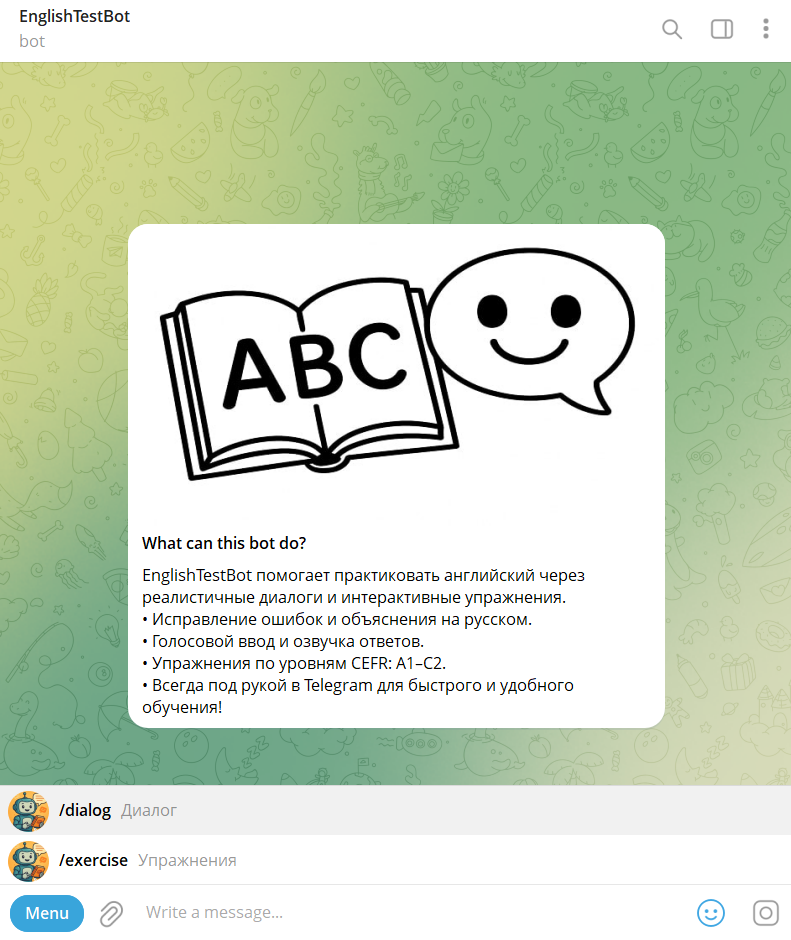

## **Режимы бота:** (показваем)

**Диалог**

После выбора режима диалога в меню Вам будет предоставлены 5 случайных возможных сценариев с обозначением места диалога, Вашей роли и роли бота. Для продолжения нужно выбрать одну из ситуаций, либо обновить их, нажав повторно диалог в меню бота.

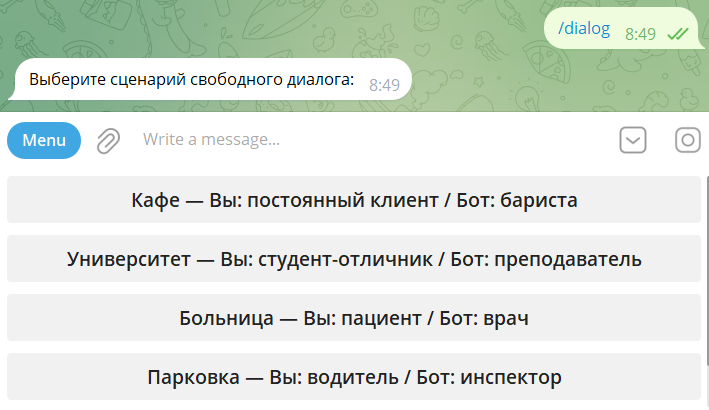

Если включить звук, то ответы от бота также будут приходить в звуковом формате и их можно прослушать. Записывать свою речь можно в любом режиме.

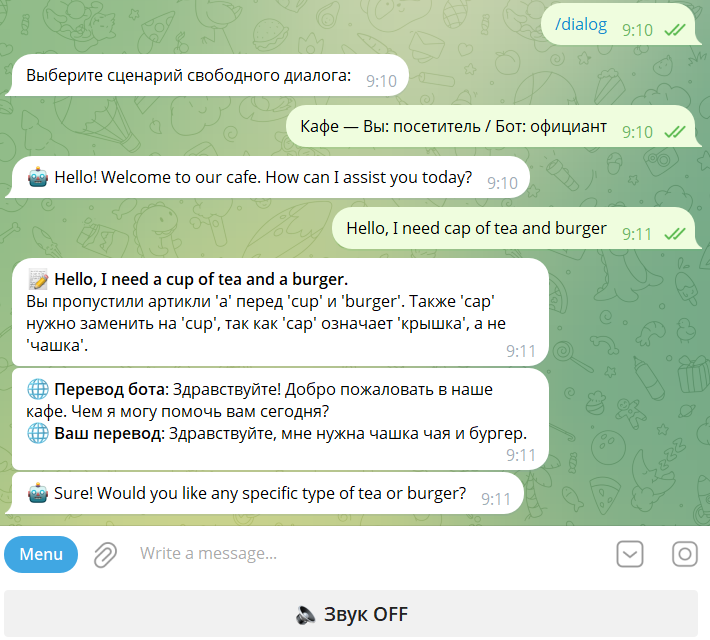

**Упражнения**

При выборе блока упражнения для начала нужно выбрать Ваш уровень:

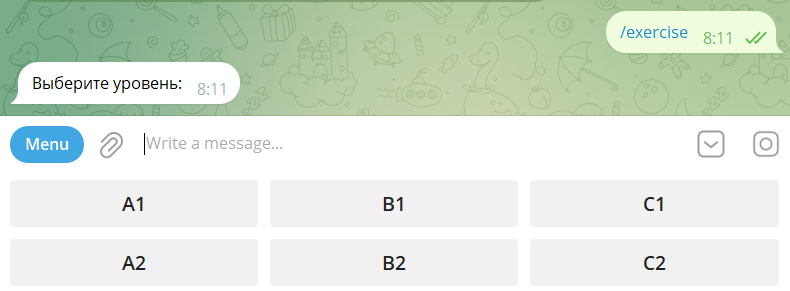

**Уровни владения английским (CEFR)**

- **A1 (Beginner / Начальный)**  
  Понимает и использует знакомые повседневные выражения и очень простые фразы, направленные на удовлетворение конкретных потребностей. Может представиться, задать и ответить на простые вопросы о себе (имя, место жительства, работа, учеба).

- **A2 (Elementary / Элементарный)**  
  Понимает отдельные предложения и часто употребляемые выражения, связанные с наиболее важными сферами (например, информация о семье, покупках, местном регионе). Может общаться в простых и рутинных ситуациях, требующих прямого обмена информацией.

- **B1 (Intermediate / Средний)**  
  Понимает основные моменты чёткой стандартной речи на знакомые темы (работа, учеба, досуг). Может справляться с большинством ситуаций во время путешествий. Умеет описывать опыты и события, мечты, надежды и амбиции, а также кратко излагать причины и объяснять планы.

- **B2 (Upper‐Intermediate / Выше среднего)**  
  Понимает основное содержание сложных текстов на конкретные и абстрактные темы, включая технические обсуждения в своей специальности. Может общаться с носителями языка достаточно бегло и спонтанно, чтобы поддерживать обычный разговор без напряжения для обеих сторон.

- **C1 (Advanced / Продвинутый)**  
  Понимает широкий спектр сложных и длинных текстов, а также распознаёт скрытый смысл. Умеет свободно и спонтанно выражать мысли без явного поиска выражений, использовать язык гибко и эффективно для социальных, академических и профессиональных целей.

- **C2 (Proficiency / Владение на уровне носителя)**  
  Понимает практически всё услышанное или прочитанное с лёгкостью. Может структурировать информацию из различных устных и письменных источников, реконструируя аргументы и рассказы в связное изложение. Способен выражаться спонтанно, очень бегло и точно, различая тонкие оттенки смысла даже в сложных ситуациях.


Потом выбрать тему упражнения:

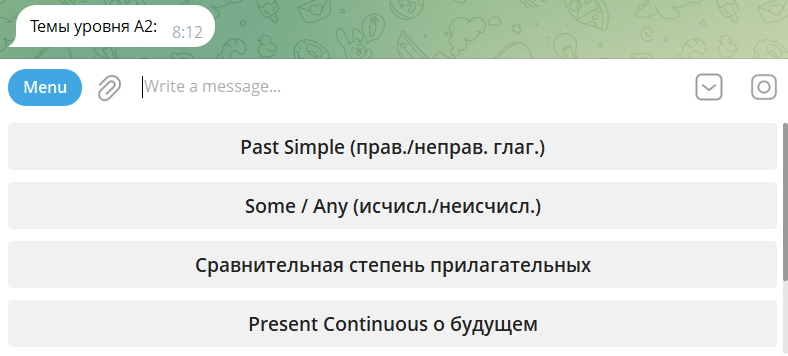

Затем появится задание, которое можно выполнить или пропустить. Для правилного выполнения задания допускается любая произвольная форма ответа.

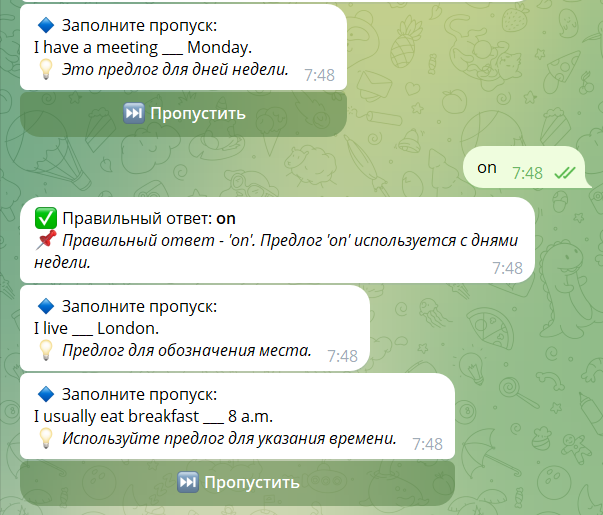

## **Основные «состояния» бота** (показываем)

- **`session`**  
  Хранит «долгую» память по каждому чату: текущий режим (`mode`), историю сообщений (`history`), флаг озвучки (`tts`), правильный ответ и правило упражнения (`ex_answer`, `ex_rule`) и прочие данные, которые нужны между сообщениями.

- **`state`**  
  Вспомогательный словарь только для режима «Упражнения» — запоминает, какой уровень и тема выбраны, пока пользователь не завершит серию заданий.

## **Промты и вспомогательные данные** (показываем)

**Системный промт генерации 5 случайных сценариев в режиме диалога** (seed - 2025-08-03T12:34:56 - трюк prompt-engineering, чтобы сценарии действительно менялись при каждом новом вызове, n - количество сценариев)

In [ ]:
SCENARIO_BUILDER_PROMPT = """
seed:{seed}
Придумай {n} разных жизненных ситуаций для ролевого диалога.
Для каждой ровно ОДНУ строку, строго в формате:
Место — Вы: роль_пользователя / Бот: роль_бота

Требования:
• «Место» — одно русское слово без пробелов.
• Роли различаются между собой и не совпадают с «местом».
• Никакой нумерации, кавычек, пустых строк и лишних символов.
"""

**Системный промт правил общения режима диалога** (задаёт место, роли — для генерации реплик бота в англоязычном чате)

In [ ]:
BOT_DIALOGUE_PROMPT = """
Вы участвуете в следующей ситуации:
• Место: {place}
• Ваша роль (ассистент): {bot_role}
• Роль учащегося: {user_role}

ПРАВИЛА:
1. Говорите ТОЛЬКО как {bot_role}. Никогда не говорите за учащегося.
2. Отвечайте ТОЛЬКО на английском (без русского, кириллицы и смешения языков).
3. 1–3 коротких вежливых предложения; всегда заканчивайте встречным вопросом.
4. НЕ объясняйте грамматику.
"""

**Системный промт грамматического корректора в режиме диалога**

In [ ]:
GRAMMAR_TUTOR_PROMPT = """
Вы — преподаватель английского. Для каждого входного предложения:
1. Если есть ошибки, покажите исправленный вариант и кратко объясните ошибки на русском (≤ 2 предложения).
2. Если ошибок нет, верните оригинал и в объяснении напишите «Все верно!».

Верните JSON:
{"corrected":"...", "explanation_ru":"..."}

‼️ Важно:
• Отвечайте только по-русски.
• Используйте кириллицу, латиницу, цифры и стандартную пунктуацию.
• Никаких иероглифов, эмодзи и других алфавитов.
"""

**Системный промт вспомогательного перевода в режиме диалога** (английские фразы бота и пользователя переводит на русский язык)

In [ ]:
TRANSLATE_PROMPT = """
Вы — переводчик. Переведите оба предложения ТОЛЬКО на русский язык
и верните JSON строго в заданном формате.

предыдущее_сообщение_бота: "{bot}"
сообщение_пользователя: "{user}"

Верните JSON:
{{"translation_bot":"...","translation_user":"..."}}
"""

**Список стоп-слов в режиме диалога** для завершения диалога

In [ ]:
EXIT_WORDS = {"bye", "goodbye", "see you later", "good bye"}

**Список уровней в режиме упражнений**

In [ ]:
LEVELS = ["A1", "A2", "B1", "B2", "C1", "C2"]

**Список тем в режиме упражнений**, закрепленных за каждым уровнем

In [ ]:
TOPICS = {
    "A1": [
        "Неопределённый артикль a/an",
        "Определённый артикль the",
        "There is / There are",
        "Притяжательное 's",
        "Предлоги места in/on/at",
        "Present Simple (be)"
    ],
    "A2": [
        "Past Simple (прав./неправ. глаг.)",
        "Some / Any (исчисл./неисчисл.)",
        "Сравнительная степень прилагательных",
        "Present Continuous о будущем",
        "Be going to (планы)",
        "Past Continuous"
    ],
    "B1": [
        "Present Perfect vs Past Simple",
        "Модальные can / could / must",
        "First Conditional (if + will)",
        "Возвратные местоимения",
        "Сравнительные наречия",
        "Gerund vs Infinitive"
    ],
    "B2": [
        "Пассив во всех временах",
        "Косвенная речь (утверждения)",
        "Относительные придаточные (who/which)",
        "Second Conditional",
        "Used to / Would (привычки)",
        "Future Perfect"
    ],
    "C1": [
        "Инверсия для усиления",
        "Смешанные условные",
        "Клефт‑предложения (cleft)",
        "Причастные обороты",
        "Modal Perfects (might have V‑ed)",
        "Wish / If only"
    ],
    "C2": [
        "Субжунктивные структуры",
        "Эллипсис / субституция",
        "Фронтинг",
        "Номинализация",
        "Сложная инверсия",
        "Комплексные номинальные клаузы"
    ]
}

**Список якорных слов в режиме упражнений** для контролируемой генерации упражнений каждого уровня

In [ ]:
TOPIC_WORDS = {
    # ------- A1 -------
    "Неопределённый артикль a/an"          : ["a", "an"],
    "Определённый артикль the"             : ["the", "a", "an"],
    "There is / There are"                 : ["there", "is", "are"],
    "Притяжательное 's"                    : ["'s", "my", "his", "her"],
    "Предлоги места in/on/at"              : ["in", "on", "at"],
    "Present Simple (be)"                  : ["am", "is", "are"],
    # ------- A2 -------
    "Past Simple (прав./неправ. глаг.)"    : ["played", "went", "did"],
    "Some / Any (исчисл./неисчисл.)"       : ["some", "any"],
    "Сравнительная степень прилагательных": ["bigger", "more"],
    "Present Continuous о будущем"         : ["am", "is", "are"],
    "Be going to (планы)"                  : ["going", "to"],
    "Past Continuous"                      : ["was", "were"],
    # ------- B1 -------
    "Present Perfect vs Past Simple"       : ["have", "has", "did"],
    "Модальные can / could / must"         : ["can", "could", "must"],
    "First Conditional (if + will)"        : ["if", "will"],
    "Возвратные местоимения"               : ["myself", "yourself"],
    "Сравнительные наречия"                : ["faster", "more"],
    "Gerund vs Infinitive"                 : ["to", "ing"],
    # ------- B2 -------
    "Пассив во всех временах"              : ["was", "were", "been"],
    "Косвенная речь (утверждения)"         : ["said", "told"],
    "Относительные придаточные (who/which)": ["who", "which", "that"],
    "Second Conditional"                   : ["would"],
    "Used to / Would (привычки)"           : ["used", "would"],
    "Future Perfect"                       : ["will", "have"],
    # ------- C1 -------
    "Инверсия для усиления"                : ["seldom", "never"],
    "Смешанные условные"                   : ["had", "would"],
    "Клефт‑предложения (cleft)"            : ["it", "was"],
    "Причастные обороты"                   : ["having", "seen"],
    "Modal Perfects (might have V‑ed)"     : ["might", "have"],
    "Wish / If only"                       : ["wish", "if"],
    # ------- C2 -------
    "Субжунктивные структуры"              : ["suggest", "demand"],
    "Эллипсис / субституция"               : ["so", "do"],
    "Фронтинг"                             : ["only", "when"],
    "Номинализация"                        : ["development", "arrival"],
    "Сложная инверсия"                     : ["should", "you"],
    "Комплексные номинальные клаузы"       : ["that", "which"]
}

**Системный промт создания упражнения в режиме упражнений** по выбранному уровню и теме

In [ ]:
EXERCISE_PROMPT = """
Сформируй ОДНО упражнение формата «вставь пропуск» (fill‑in‑the‑blank).

Требования к вопросу
• Одно английское предложение ≤ 15 слов.
• Тренируется ровно ОДНА грамматическая структура, подходящая уровню {level}.
• Целевое слово / форма заменяется на ___ (три подчёркивания).
• В самом предложении никаких подсказок, скобок или перевода!

Поле "hint"
• 1‑2 коротких фразы по‑русски, описывающие правило **без раскрытия ответа**
  (смысловой намёк допускается без упоминания точного ответа, точного слова, совпадающего с ответом в подсказке быть не должно).

Поле "explanation"
• Чёткое объяснение правила с указанием правильного ответа по-русски.

Верни СТРОГО JSON (ничего лишнего!):

{{
  "question": "...",     # предложение с ___
  "answer"  : "...",     # только нужная форма без скобок
  "hint"    : "...",     # подсказка правила без ответа
  "explanation": "..."   # объяснение правила с правильным ответом
}}
"""

## **Реплай и инлайн кнопки** (показываем)

РЕЖИМ ДИАЛОГА

In [ ]:
async def build_scenarios_kb(lines: list[str]) -> ReplyKeyboardMarkup:
    """
    Принимаем список готовых строк-сценариев и
    превращаем его в вертикальное меню.
    """
    return ReplyKeyboardMarkup(
        resize_keyboard=True,
        keyboard=[[KeyboardButton(text=line)] for line in lines]
    )

def sound_kb(cid: int) -> ReplyKeyboardMarkup:
    """
    Клавиатура с одной кнопкой-переключателем «Звук ON/OFF».
    """
    return ReplyKeyboardMarkup(
        resize_keyboard=True,
        keyboard=[[KeyboardButton(text=sound_label(cid))]]
    )

РЕЖИМ УПРАЖНЕНИЙ

In [ ]:
def levels_kb() -> ReplyKeyboardMarkup:
    """
    Создаёт Reply-клавиатуру с уровнями CEFR (A1–C2),
    располагая по две кнопки в каждой строке.
    """
    return ReplyKeyboardMarkup(
        resize_keyboard=True,
        keyboard=[
            [KeyboardButton(text="A1"), KeyboardButton(text="A2")],
            [KeyboardButton(text="B1"), KeyboardButton(text="B2")],
            [KeyboardButton(text="C1"), KeyboardButton(text="C2")],
        ]
    )

def topics_kb(level: str) -> ReplyKeyboardMarkup:
    """
    Создаёт Reply-клавиатуру со списком тем для заданного уровня,
    по одной кнопке в каждой строке.
    """
    return ReplyKeyboardMarkup(
        resize_keyboard=True,
        keyboard=[[KeyboardButton(text=topic)] for topic in TOPICS[level]]
    )

def skip_kb() -> InlineKeyboardMarkup:
    """
    Создаёт Inline-клавиатуру с одной кнопкой «⏭ Пропустить»,
    используемой для перехода к следующему упражнению.
    """
    return InlineKeyboardMarkup(
        inline_keyboard=[
            [InlineKeyboardButton(text="⏭ Пропустить", callback_data="ex:skip")]
        ]
    )

## **Рабочие функции** (показываем)

ФУНКЦИИ РЕЖИМА «ДИАЛОГ

In [ ]:
async def dialogue_step(m: Message, user_text: str):
    """Обработчик: проверяем «bye», правим ошибки, переводим, просим GPT ответить и озвучиваем."""
    # 1. Грамматика
    gram = await grammar_feedback(user_text)
    # 2. Перевод
    trans = await translate_ru("...", user_text)
    # 3. Ответ GPT
    reply = await gpt_reply(user_text)
    # Отправляем всё
    await m.answer(gram)
    await m.answer(f"🌐 Бот: {trans['bot']}\n🌐 Вы: {trans['user']}")
    await m.answer(f"🤖 {reply}")
    # 4. TTS
    await tts_and_send(reply, m.chat.id)

async def gpt_reply(user_text: str) -> str:
    """Обращяемся к GPT-4o-mini для подготовки ответа на реплику пользователя."""
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":user_text}],
        temperature=0.7
    )
    return extract_message_content(r)

async def grammar_feedback(text: str) -> str:
    """GPT-4o-mini исправляет ошибки и коротко объясняет их по-русски."""
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role":"system","content":GRAMMAR_TUTOR_PROMPT},
            {"role":"user","content":text}
        ],
        temperature=0
    )
    return format_grammar_feedback(extract_json(r))

async def translate_ru(prev: str, user: str) -> dict:
    """GPT-4o-mini переводит реплику бота и ученика на русский язык."""
    prompt = TRANSLATE_PROMPT.format(bot=prev, user=user)
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":prompt}],
        temperature=0
    )
    return extract_json(r)

async def transcribe_voice(v: Voice) -> str:
    """Преобразуем voice-сообщение в английский текст через gpt-4o-mini-transcribe."""
    ogg = await _download_voice(v)               # скачали файл
    stt = await transcribe_file(ogg)             # получили ответ модели
    return extract_transcript_text(stt)          # вернули чистый текст

async def tts_and_send(text: str, cid: int):
    """Если звук включён — делаем mp3 и отправляем в чат."""
    if not is_tts_enabled(cid): # проверяем включена ли озвучка
        return
    mp3 = _generate_tts_file(text)
    await bot.send_audio(cid, FSInputFile(mp3, "reply.mp3"), title="Tutor")

ФУНКЦИИ РЕЖИМА УПРАЖНЕНИЯ

In [ ]:
async def is_answer_correct(user: str, correct: str) -> bool:
    """Обработчик: спрашиваем GPT-4o-mini, совпадает ли смысл ответа с правильным."""
    prompt = f'Ожидаемый: "{correct}"\nУченик: "{user}"\n"yes" или "no"?'
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role":"user","content":prompt}],
        temperature=0
    )
    return extract_bool(r)

async def make_exercise(info: dict) -> dict:
    """Обработчик: просим GPT-4o-mini создать JSON-задание по заданной теме и уровню."""
    prompt = EXERCISE_PROMPT.format(**info)
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role":"system","content":"Return ONLY JSON."},
            {"role":"user","content":prompt}
        ],
        temperature=0.7
    )
    return extract_json(r)

## **Обработчики сообщений** (показываем)

ОСНОВНЫЕ КОМАНДЫ

In [ ]:
@public.message(Command("start"))
async def cmd_start(m: Message):
    """Обработчик команды /start — очищает данные пользователя и предлагает выбрать режим."""
    await _start(m)

@public.message(Command("stop"))
async def cmd_stop(m: Message):
    """Обработчик команды /stop — останавливает бота и сбрасывает состояние."""
    await _stop(m)

ВЫБОР РЕЖИМА

In [ ]:
@public.message(Command("dialog"))
async def cmd_dialog(m: Message):
    """Обработчик команды /dialog — запускает свободный диалог и показывает 5 сценариев."""
    await _cmd_dialog(m)

@public.message(Command("exercise"))
async def cmd_exercise(m: Message):
    """Обработчик команды /exercise — запускает упражнение и просит выбрать уровень A1–C2."""
    await _cmd_ex(m)

ДИАЛОГ (текст / голос / кнопка «🔈»)

In [ ]:
@public.message(lambda m: session[m.chat.id].get("mode") == "chat_wait" and " — " in m.text)
async def start_dialogue(m: Message):
    """Обработчик выбора сценария — запускаем диалог по заданному сценарию."""
    await _choose_scenario(m)

@public.message(lambda m: session[m.chat.id]["mode"] == "chat" and m.text and not m.text.startswith("🔈"))
async def dialogue_text(m: Message):
    """Обработчик пользовательского текста в диалоге — бот отвечает через GPT."""
    await _chat_text(m)

@public.message(lambda m: session[m.chat.id]["mode"] == "chat" and m.voice)
async def dialogue_voice(m: Message):
    """Обработчик голосового сообщения — бот распознаёт речь и отвечает."""
    await _chat_voice(m)

@public.message(lambda m: m.text and m.text.startswith("🔈"))
async def toggle_sound(m: Message):
    """Обработчик кнопки «🔈» — переключаем озвучку ответов (TTS on/off)."""
    await _toggle_tts(m)

УПРАЖНЕНИЯ

In [ ]:
@public.message(lambda m: session[m.chat.id]["mode"] == "exercise_wait_level" and m.text in LEVELS)
async def ask_topic(m: Message):
    """Обработчик: пользователь выбрал уровень — показываем список тем."""
    await _pick_level(m)

@public.message(lambda m: session[m.chat.id]["mode"] == "exercise_wait_topic")
async def send_first_ex(m: Message):
    """Обработчик: пользователь выбрал тему — создаём первое упражнение."""
    await _pick_topic(m)

@public.callback_query(F.data == "ex:skip")
async def ex_skip(c: CallbackQuery):
    """Обработчик: нажали «Пропустить» — показываем следующее упражнение."""
    await _skip(c)

@public.message(lambda m: session[m.chat.id]["mode"] == "exercise")
async def ex_check(m: Message):
    """Обработчик: проверяем ответ на упражнение и показываем результат."""
    await _check_answer(m)

ОСТАЛЬНЫЕ СООБЩЕНИЯ ВНЕ РЕЖИМОВ ДИАЛОГА И УПРАЖНЕНИЙ

In [ ]:
@public.message()
async def fallback(m: Message):
    """Обработчик: если режим не выбран — подсказываем, что выбрать Диалог или Упражнения."""
    await _fb(m)

In [ ]:
# Запускаем бота
run_bot()

## **ОБЩИЙ БЛОК ЗАПУСКА БОТА**

In [ ]:
#@title Полный код телеграм бота (запускать после каждой остановки бота)

SCENARIO_BUILDER_PROMPT = """
seed:{seed}
Придумай {n} разных жизненных ситуаций для ролевого диалога.
Для каждой ровно ОДНУ строку, строго в формате:
Место — Вы: роль_пользователя / Бот: роль_бота

Требования:
• «Место» — одно русское слово без пробелов.
• Роли различаются между собой и не совпадают с «местом».
• Никакой нумерации, кавычек, пустых строк и лишних символов.
"""

# Сценарий свободного диалога: задаёт место, роли — для генерации реплик бота в англоязычном чате
BOT_DIALOGUE_PROMPT = """
Вы участвуете в следующей ситуации:
• Место: {place}
• Ваша роль (ассистент): {bot_role}
• Роль учащегося: {user_role}

ПРАВИЛА:
1. Говорите ТОЛЬКО как {bot_role}. Никогда не говорите за учащегося.
2. Отвечайте ТОЛЬКО на английском (без русского, кириллицы и смешения языков).
3. 1–3 коротких вежливых предложения; всегда заканчивайте встречным вопросом.
4. НЕ объясняйте грамматику.
"""

# Грамматический корректор: исправляет предложение ученика и кратко объясняет ошибку на русском
GRAMMAR_TUTOR_PROMPT = """
Вы — преподаватель английского. Для каждого входного предложения:
1. Если есть ошибки, покажите исправленный вариант и кратко объясните ошибки на русском (≤ 2 предложения).
2. Если ошибок нет, верните оригинал и в объяснении напишите «Все верно!».

Верните JSON:
{"corrected":"...", "explanation_ru":"..."}

‼️ Важно:
• Отвечайте только по-русски.
• Используйте кириллицу, латиницу, цифры и стандартную пунктуацию.
• Никаких иероглифов, эмодзи и других алфавитов.
"""

# Переводчик для двустороннего перевода: берёт последний вопрос бота и ответ ученика, возвращает оба перевода на русский
TRANSLATE_PROMPT = """
Вы — переводчик. Переведите оба предложения ТОЛЬКО на русский язык
и верните JSON строго в заданном формате.

предыдущее_сообщение_бота: "{bot}"
сообщение_пользователя: "{user}"

Верните JSON:
{{"translation_bot":"...","translation_user":"..."}}
"""


# Стоп-слова для завершения диалога
EXIT_WORDS = {"bye", "goodbye", "see you later", "good bye"}


# ------------------ Генератор упражнения ------------------
EXERCISE_PROMPT = """
Сформируй ОДНО упражнение формата «вставь пропуск» (fill‑in‑the‑blank).

Требования к вопросу
• Одно английское предложение ≤ 15 слов.
• Тренируется ровно ОДНА грамматическая структура, подходящая уровню {level}.
• Целевое слово / форма заменяется на ___ (три подчёркивания).
• В самом предложении никаких подсказок, скобок или перевода!

Поле "hint"
• 1‑2 коротких фразы по‑русски, описывающие правило **без раскрытия ответа**
  (смысловой намёк допускается без упоминания точного ответа, точного слова, совпадающего с ответом в подсказке быть не должно).

Поле "explanation"
• Чёткое объяснение правила с указанием правильного ответа по-русски.

Верни СТРОГО JSON (ничего лишнего!):

{{
  "question": "...",     # предложение с ___
  "answer"  : "...",     # только нужная форма без скобок
  "hint"    : "...",     # подсказка правила без ответа
  "explanation": "..."   # объяснение правила с правильным ответом
}}
"""


# ------------------ CEFR‑уровни ------------------
LEVELS = ["A1", "A2", "B1", "B2", "C1", "C2"]


# ------------------ Грамматические темы ------------------
TOPICS = {
    "A1": [
        "Неопределённый артикль a/an",
        "Определённый артикль the",
        "There is / There are",
        "Притяжательное 's",
        "Предлоги места in/on/at",
        "Present Simple (be)"
    ],
    "A2": [
        "Past Simple (прав./неправ. глаг.)",
        "Some / Any (исчисл./неисчисл.)",
        "Сравнительная степень прилагательных",
        "Present Continuous о будущем",
        "Be going to (планы)",
        "Past Continuous"
    ],
    "B1": [
        "Present Perfect vs Past Simple",
        "Модальные can / could / must",
        "First Conditional (if + will)",
        "Возвратные местоимения",
        "Сравнительные наречия",
        "Gerund vs Infinitive"
    ],
    "B2": [
        "Пассив во всех временах",
        "Косвенная речь (утверждения)",
        "Относительные придаточные (who/which)",
        "Second Conditional",
        "Used to / Would (привычки)",
        "Future Perfect"
    ],
    "C1": [
        "Инверсия для усиления",
        "Смешанные условные",
        "Клефт‑предложения (cleft)",
        "Причастные обороты",
        "Modal Perfects (might have V‑ed)",
        "Wish / If only"
    ],
    "C2": [
        "Субжунктивные структуры",
        "Эллипсис / субституция",
        "Фронтинг",
        "Номинализация",
        "Сложная инверсия",
        "Комплексные номинальные клаузы"
    ]
}


# ------------------ «Якорные» слова ------------------
TOPIC_WORDS = {
    # ------- A1 -------
    "Неопределённый артикль a/an"          : ["a", "an"],
    "Определённый артикль the"             : ["the", "a", "an"],
    "There is / There are"                 : ["there", "is", "are"],
    "Притяжательное 's"                    : ["'s", "my", "his", "her"],
    "Предлоги места in/on/at"              : ["in", "on", "at"],
    "Present Simple (be)"                  : ["am", "is", "are"],
    # ------- A2 -------
    "Past Simple (прав./неправ. глаг.)"    : ["played", "went", "did"],
    "Some / Any (исчисл./неисчисл.)"       : ["some", "any"],
    "Сравнительная степень прилагательных": ["bigger", "more"],
    "Present Continuous о будущем"         : ["am", "is", "are"],
    "Be going to (планы)"                  : ["going", "to"],
    "Past Continuous"                      : ["was", "were"],
    # ------- B1 -------
    "Present Perfect vs Past Simple"       : ["have", "has", "did"],
    "Модальные can / could / must"         : ["can", "could", "must"],
    "First Conditional (if + will)"        : ["if", "will"],
    "Возвратные местоимения"               : ["myself", "yourself"],
    "Сравнительные наречия"                : ["faster", "more"],
    "Gerund vs Infinitive"                 : ["to", "ing"],
    # ------- B2 -------
    "Пассив во всех временах"              : ["was", "were", "been"],
    "Косвенная речь (утверждения)"         : ["said", "told"],
    "Относительные придаточные (who/which)": ["who", "which", "that"],
    "Second Conditional"                   : ["would"],
    "Used to / Would (привычки)"           : ["used", "would"],
    "Future Perfect"                       : ["will", "have"],
    # ------- C1 -------
    "Инверсия для усиления"                : ["seldom", "never"],
    "Смешанные условные"                   : ["had", "would"],
    "Клефт‑предложения (cleft)"            : ["it", "was"],
    "Причастные обороты"                   : ["having", "seen"],
    "Modal Perfects (might have V‑ed)"     : ["might", "have"],
    "Wish / If only"                       : ["wish", "if"],
    # ------- C2 -------
    "Субжунктивные структуры"              : ["suggest", "demand"],
    "Эллипсис / субституция"               : ["so", "do"],
    "Фронтинг"                             : ["only", "when"],
    "Номинализация"                        : ["development", "arrival"],
    "Сложная инверсия"                     : ["should", "you"],
    "Комплексные номинальные клаузы"       : ["that", "which"]
}

def setup_bot():
    def log(cid, txt):
        print(txt, flush=True)

    # 1) создаём HTTP-сессию с таймаутом в 20 секунд
    session_http = AiohttpSession(timeout=20)

    # 2) инициализируем Bot через эту сессию
    bot = Bot(
        TG_BOT_TOKEN,
        parse_mode="HTML",
        session=session_http
    )

    # 3) Dispatcher и Router оставляем как есть
    dp = Dispatcher()
    router = Router()
    dp.include_router(router)

    # 4) OpenAI-клиент: если ему нужен таймаут — передайте его в конструктор
    client = AsyncOpenAI(timeout=20)

    # 5) Словарь сессий пользователей
    session = collections.defaultdict(lambda: {
        "mode": None,
        "history": [],
        "ex_answer": None,
        "tts": False
    })

    return bot, dp, router, client, session, log

bot, dp, router, client, session, log = setup_bot()


# ---------- KEYBOARDS ----------
def sound_label(cid):
    return "🔈 Звук ON" if session[cid]["tts"] else "🔈 Звук OFF"


def sound_kb(cid):
    return ReplyKeyboardMarkup(resize_keyboard=True,
                               keyboard=[[KeyboardButton(text=sound_label(cid))]])


def levels_kb():
    buttons = [KeyboardButton(text=l) for l in LEVELS]
    row1 = [buttons[i] for i in range(0, len(buttons), 2)]
    row2 = [buttons[i] for i in range(1, len(buttons), 2)]
    return ReplyKeyboardMarkup(resize_keyboard=True, keyboard=[row1, row2])


def topics_kb(level):
    return ReplyKeyboardMarkup(resize_keyboard=True,
                               keyboard=[[KeyboardButton(text=t)] for t in TOPICS[level]])


def skip_kb():
    return InlineKeyboardMarkup(inline_keyboard=[
        [InlineKeyboardButton(text="⏭ Пропустить", callback_data="ex:skip")]
    ])

# ---------- AUDIO ----------
async def transcribe_voice(v: types.Voice) -> str:
    """
    Преобразует voice-сообщение в текст (английский).
    При любых ошибках логирует их и возвращает пустую строку.
    """
    try:
        with tempfile.TemporaryDirectory() as tmp:
            ogg = pathlib.Path(tmp) / f"{v.file_unique_id}.ogg"
            await bot.download(v, ogg)

            # ① базовая транскрипция
            with ogg.open("rb") as f:
                resp = await client.audio.transcriptions.create(
                    model="gpt-4o-mini-transcribe",
                    file=f,
                    language="en",
                    prompt="Transcribe only in English letters.",
                    temperature=0
                )
            txt = (resp.text or "").strip()

            # ② если внутри не-латиница → повторно через translations
            if re.search(r"[^A-Za-z0-9 ,.!?'\\-]", txt):
                with ogg.open("rb") as f:
                    resp = await client.audio.translations.create(
                        model="gpt-4o-mini-transcribe",
                        file=f,
                        response_format="text"
                    )
                txt = (resp.text or "").strip()

            return txt

    except Exception as e:
        # Вместо того, чтобы падать, логируем и возвращаем пустую строку
        log(None, f"⚠️ Ошибка транскрипции: {e}")
        return ""

async def tts_and_send(text, cid):
    if not session[cid]["tts"]:
        return
    with tempfile.NamedTemporaryFile(suffix=".mp3") as tmp:
        gTTS(text, lang="en").save(tmp.name)
        await bot.send_audio(cid, FSInputFile(tmp.name, "reply.mp3"), title="Tutor")

# ---------- GPT HELPERS ----------
async def complete_with_history(system_prompt, history, user):
    msgs = ([{"role": "system", "content": system_prompt}] +
            history[-10:] +
            [{"role": "user", "content": user}])
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=msgs,
        temperature=0.6
    )
    return r.choices[0].message.content


async def grammar_feedback(text):
    j = json.loads(await complete_with_history(GRAMMAR_TUTOR_PROMPT, [], text))
    return f"📝 <b>{j['corrected']}</b>\n{j['explanation_ru']}"


async def translate_ru(prev_bot, user_msg):
    prompt = TRANSLATE_PROMPT.format(bot=prev_bot, user=user_msg)
    try:
        j = json.loads(await complete_with_history("", [], prompt))
        return {"bot": j.get("translation_bot", "(нет)"),
                "user": j.get("translation_user", "(нет)")}
    except:
        return {"bot": "(ошибка)", "user": "(ошибка)"}


async def make_exercise(info):
    extra = f'\n• Use the word “{info["keyword"]}” (or its correct form) in the sentence.' if info.get("keyword") else ""
    sp = EXERCISE_PROMPT.format(level=info["level"], topic=info["topic"]) + extra
    raw = await complete_with_history(sp, [], "Return ONLY JSON.")
    raw = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.S)
    data = json.loads(raw)
    return {
        "question": data["question"].strip(),
        "answer": data["answer"].strip().lower(),
        "hint": data.get("hint", "").strip(),
        "explanation": data.get("explanation", "").strip()
    }


async def is_answer_correct(user, correct):
    prompt = f'Answer checking.\nExpected answer: "{correct}".\nStudent wrote: "{user}".\nReturn "yes" if the meaning is identical, else "no".'
    r = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return "yes" in r.choices[0].message.content.lower()


async def build_scenarios_kb(n: int = 5) -> ReplyKeyboardMarkup:
    seed = datetime.datetime.utcnow().isoformat(timespec="seconds")
    prompt = SCENARIO_BUILDER_PROMPT.format(seed=seed, n=n)
    resp = await client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.9
    )
    lines = [
        ln.strip()
        for ln in resp.choices[0].message.content.splitlines()
        if " — " in ln and " / " in ln
    ]
    while len(lines) < n:
        fake_place = random.choice(["Кафе", "Парк", "Поезд"])
        fake_roles = random.sample(
            ["Клиент", "Покупатель", "Пассажир", "Менеджер"], 2
        )
        lines.append(f"{fake_place} — Вы: {fake_roles[0]} / Бот: {fake_roles[1]}")
    rows = [[KeyboardButton(text=ln)] for ln in lines[:n]]
    return ReplyKeyboardMarkup(resize_keyboard=True, keyboard=rows)

# ---------- COMMAND HANDLERS ----------
@router.message(Command("dialog"))
@router.message(F.text == "Диалог")
async def cmd_dialog(m: Message):
    cid = m.chat.id
    session[cid] = {"mode": "chat_wait", "history": [], "tts": session[cid]["tts"]}
    kb = await build_scenarios_kb()
    await m.answer("Выберите сценарий свободного диалога:", reply_markup=kb)
    log(cid, "Режим выбора сценария")


@router.message(Command("exercise"))
@router.message(F.text == "Упражнения")
async def cmd_exercise(m: Message):
    cid = m.chat.id
    session[cid] = {"mode": "exercise_wait_level", "tts": session[cid]["tts"]}
    await m.answer("Выберите уровень:", reply_markup=levels_kb())
    log(cid, "Стадия выбора уровня")


@router.message(lambda m: session[m.chat.id].get("mode") == "chat_wait" and " — " in m.text)
async def start_dialogue(m: Message):
    cid = m.chat.id
    place, roles = m.text.split(" — ")
    user_role, bot_role = roles.split("/")
    session[cid].update(mode="chat",
                        place=place.strip(),
                        user_role=user_role.strip(),
                        bot_role=bot_role.strip())
    log(cid, f"Выбранный сценарий: place={place.strip()}, user_role={user_role.strip()}, bot_role={bot_role.strip()}")
    greet = await complete_with_history(BOT_DIALOGUE_PROMPT.format(**session[cid]), [], "Start the conversation.")
    log(cid, f"БОТ: {greet}")
    session[cid]["history"].append({"role": "assistant", "content": greet})
    await m.answer(f"🤖 {greet}", reply_markup=sound_kb(cid))
    await tts_and_send(greet, cid)

@router.message(lambda m: session[m.chat.id]["mode"] == "chat" and m.text and not m.text.startswith("🔈 "))
async def dialogue_text(m: Message):
    await _dialogue_step(m, m.text)

@router.message(lambda m: session[m.chat.id]["mode"] == "chat" and m.voice)
async def dialogue_voice(m: Message):
    try:
        txt = await transcribe_voice(m.voice)
    except Exception as e:
        await m.answer(f"❌ Не удалось распознать голос: {e}")
        return
    await m.answer(f"🗣 <i>Вы сказали:</i> {txt}")
    await _dialogue_step(m, txt)

# ---------- DIALOGUE STEP ----------
async def _dialogue_step(m: Message, user_text: str):
    cid = m.chat.id
    s = session[cid]
    if any(w in user_text.lower() for w in EXIT_WORDS):
        log(cid, "Диалог завершен")
        session[cid] = {"mode": None, "history": [], "ex_answer": None, "tts": s["tts"]}
        await m.answer("🛑 Диалог завершён. Выберите в меню Бота: «Диалог» или «Упражнения».", reply_markup=sound_kb(cid))
        return
    s["history"].append({"role": "user", "content": user_text})
    log(cid, f"ПОЛЬЗОВАТЕЛЬ: {user_text}")
    feedback = await grammar_feedback(user_text)
    await m.answer(feedback, reply_markup=sound_kb(cid))
    last_bot = next((msg["content"] for msg in reversed(s["history"]) if msg["role"] == "assistant"), "")
    tr = await translate_ru(last_bot, user_text)
    await m.answer(f"🌐 <b>Перевод бота</b>: {tr['bot']}\n🌐 <b>Ваш перевод</b>: {tr['user']}", reply_markup=sound_kb(cid))
    assistant_reply = await complete_with_history(BOT_DIALOGUE_PROMPT.format(**s), s["history"], user_text)
    s["history"].append({"role": "assistant", "content": assistant_reply})
    log(cid, f"БОТ: {assistant_reply}")
    await m.answer(f"🤖 {assistant_reply}", reply_markup=sound_kb(cid))
    await tts_and_send(assistant_reply, cid)

# ---------- EXERCISES ----------
state = {}

@router.message(lambda m: session[m.chat.id]["mode"] == "exercise_wait_level" and m.text in LEVELS)
async def ask_topic(m: Message):
    cid = m.chat.id
    lvl = m.text
    state[cid] = {"level": lvl}
    session[cid]["mode"] = "exercise_wait_topic"
    await m.answer(f"Темы уровня {lvl}:", reply_markup=topics_kb(lvl))
    log(cid, f"Level={lvl}")


@router.message(lambda m: session[m.chat.id]["mode"] == "exercise_wait_topic")
async def send_first_ex(m: Message):
    cid = m.chat.id
    state[cid].update(topic=m.text)
    log(cid, f"Topic={m.text}")
    await m.answer("▶️ Упражнение начинается…", reply_markup=ReplyKeyboardRemove())
    await _send_ex(m, state[cid])


@router.callback_query(F.data == "ex:skip")
async def ex_skip(c: CallbackQuery):
    cid = c.from_user.id
    log(cid, "Кнопка ⏭ Пропустить")
    info = state.get(cid)
    if info:
        await _send_ex(c.message, info)


@router.message(lambda m: session[m.chat.id]["mode"] == "exercise")
async def ex_check(m: Message):
    """
    Проверяет ответ ученика, показывает правильный вариант + чёткое объяснение,
    пишет лог и сразу выдаёт следующее упражнение.
    """
    cid = m.chat.id
    user_txt = (m.text or "").strip().lower()
    correct = session[cid]["ex_answer"].lower()
    explanation = session[cid].get("ex_explanation", "")  # используем explanation

    # 1) быстрая проверка: совпадает ли нужная форма среди токенов
    tokens = re.findall(r"\b\w+\b", user_txt)
    ok = correct in tokens

    # 2) если не совпало ‒ уточняем через LLM-помощника
    if not ok:
        ok = await is_answer_correct(user_txt, correct)

    mark = "✅" if ok else "❌"
    reply = f"{mark} Правильный ответ: <b>{correct}</b>"
    if explanation:
        reply += f"\n📌 <i>{explanation}</i>"

    await m.answer(reply)
    log(cid, f"Ответ: {m.text} → {'correct' if ok else 'wrong'}")

    # 3) выдаём следующее задание
    await _send_ex(m, state[cid])

async def _send_ex(prev_msg, info):
    try:
        await prev_msg.edit_reply_markup(reply_markup=None)
    except:
        pass
    topic_words = TOPIC_WORDS.get(info["topic"], [])
    used = session[prev_msg.chat.id].setdefault("kw_used", set())
    kw = random.choice([w for w in topic_words if w not in used] or topic_words)
    used.add(kw)
    info_kw = {**info, "keyword": kw}
    q = await make_exercise(info_kw)
    cid = prev_msg.chat.id

    session[cid].update(
        mode="exercise",
        ex_answer=q["answer"].lower(),
        ex_hint=q.get("hint", ""),                 # теперь отдельно hint
        ex_explanation=q.get("explanation", "")    # отдельно explanation
    )

    text = f"🔹 Заполните пропуск:\n{q['question']}"
    if q.get("hint"):
        text += f"\n💡 <i>{q['hint']}</i>"

    await bot.send_message(cid, text, reply_markup=skip_kb())
    log(cid, f"Задание: {q['question']}")

# ---------- START / STOP ----------
@router.message(F.text.in_({"/start", "Старт"}))
async def cmd_start(m: Message):
    cid = m.chat.id
    session[cid] = {"mode": None, "history": [], "ex_answer": None, "tts": False}
    await m.answer("👋 Выберите «Диалог» или «Упражнения» через меню бота.", reply_markup=ReplyKeyboardRemove())
    log(cid, "Команда START")


@router.message(F.text.in_({"/stop", "Стоп"}))
async def cmd_stop(m: Message):
    cid = m.chat.id
    session[cid] = {"mode": None, "history": [], "ex_answer": None, "tts": False}
    await m.answer("🛑 Бот остановлен. Для перезапуска — /start.")
    log(cid, "Команда STOP")
    await dp.stop_polling()

# ---------- TOGGLE SOUND ----------
@router.message(lambda m: m.text and m.text.startswith("🔈 "))
async def toggle_sound(m: Message):
    cid = m.chat.id
    session[cid]["tts"] ^= True
    state = "ON" if session[cid]["tts"] else "OFF"
    await m.answer(f"🔔 Озвучка {state}.", reply_markup=sound_kb(cid) if session[cid]["mode"] == "chat" else None)
    log(cid, f"РЕЖИМ БОТА TTS {state}")

# ---------- FALLBACK ----------
@router.message()
async def fallback(m: Message):
    cid = m.chat.id
    if session[cid]["mode"] is None:
        await m.answer("Пожалуйста, выберите режим через меню бота.\n\n• «Диалог» — сценка‑разговор с AI‑ассистентом.\n• «Упражнения» — тренировка fill‑in‑the‑blank (A1‑C2).")
        log(cid, "Информационное сообщение вне режимов Диалога и Упражнений")

# ---------- RUNNER ----------
_THREAD = "_bot_runner_thread"

def run_bot():
    old_thread = globals().get(_THREAD)
    if old_thread and old_thread.is_alive():
        print("⚠️  Бот уже запущен. Пришлите /stop в чат или дождитесь остановки.", flush=True)
        return

    # --- 1. Подавляем «красные» ERROR от aiogram ---
    logging.getLogger("aiogram.dispatcher").setLevel(logging.WARNING)
    logging.getLogger("aiogram.client.session.aiohttp").setLevel(logging.WARNING)

    dp: Dispatcher = globals()["dp"]
    bot_obj: Bot   = globals()["bot"]

    if not getattr(dp, "_stop_handler_set", False):
        @dp.message(F.text.in_({"/stop", "Стоп"}))
        async def _cmd_stop(m: Message):
            await m.answer("Бот остановлен.")
            await dp.stop_polling()
        dp._stop_handler_set = True

    # --- 2. Новый _polling — перезапуск при сетевых сбоях без стека ---
    async def _polling():
        await bot_obj.delete_webhook(drop_pending_updates=True)
        while True:
            try:
                await dp.start_polling(bot_obj, handle_signals=False)
                break                     # polling завершился — выходим
            except (TelegramNetworkError, socket.error) as e:
                log(0, f"⚠️ Сетевая ошибка, retry через 5 с: {e}")
                await asyncio.sleep(5)   # пауза и повтор
            except Exception as e:       # другие ошибки — показываем стек
                log(0, f"‼️ Неожиданная ошибка: {e!r}")
                raise

    # --- 3. Запуск в отдельном потоке без изменений ---
    def _runner():
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        try:
            loop.run_until_complete(_polling())
        finally:
            loop.close()

    t = threading.Thread(target=_runner, daemon=True)
    globals()[_THREAD] = t
    t.start()

    print("🤖 Бот запущен! Напишите /start в Telegram.", flush=True)
    print("Чтобы остановить Бота — /stop.", flush=True)

    try:
        while t.is_alive():
            time.sleep(1)
            sys.stdout.flush()
    finally:
        globals().pop(_THREAD, None)
        print("⏹ Бот полностью остановлен.", flush=True)

In [ ]:
# Запускаем бота
run_bot()

🤖 Бот запущен! Напишите /start в Telegram.
Чтобы остановить Бота — /stop.
Команда START
Режим выбора сценария
Стадия выбора уровня
Режим выбора сценария
Выбранный сценарий: place=Кафе, user_role=Вы: клиент, bot_role=Бот: официант
БОТ: Hello! Welcome to our café. How can I assist you today?
ПОЛЬЗОВАТЕЛЬ: I want something to eat.
БОТ: Sure! We have a variety of dishes. Do you prefer something light like a salad or a hearty meal?
ПОЛЬЗОВАТЕЛЬ: Yes, I want salad.
РЕЖИМ БОТА TTS ON
БОТ: Great choice! We have a Caesar salad and a Greek salad. Which one would you like?
ПОЛЬЗОВАТЕЛЬ: Yes, please.
БОТ: Would you like the Caesar salad or the Greek salad?
ПОЛЬЗОВАТЕЛЬ: I want cesar.
БОТ: Perfect! One Caesar salad coming right up. Would you like anything to drink with that?
Диалог завершен
Стадия выбора уровня
Level=A1
Topic=Неопределённый артикль a/an
Задание: I want to eat ___ apple for breakfast.
Ответ: я думаю ответ an → correct
Задание: I want to eat ___ apple for breakfast.
Кнопка ⏭ Пропусти